# Flash Analysis on untriggered samples

## Imports

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
from IPython.display import display, clear_output
import pandas as pd
import seaborn as sns

%matplotlib inline

## Constants

In [2]:
main_tree_name = 'wouterana'
flash_names = ['SimpleBeamFlashes', 'OpBeamFlashes', "SimpleCosmicFlashes", "OpCosmicFlashes"]

# Inpuyt file lists
filelist_mc = glob.glob('/home/wouter/Templates/September/cosmic_25000.root')
filelist_data = glob.glob('/home/wouter/Templates/September/data_6475.root')

## Functions

In [3]:
def load_to_dict(treename, tree_dict, file, df_out=True, branches=None):
    global main_tree_name
    tree = uproot.open(file)[main_tree_name][treename]
    # Do we want all branches?
    input_keys = tree.keys()
    if(branches):
        input_keys = branches
        
    tree = tree.arrays(input_keys)
    for key in input_keys:
        str_key = key.decode('ascii')
        if str_key in tree_dict:
            tree_dict[str_key] = np.hstack((tree_dict[str_key],tree[key]))
        else:
            tree_dict[str_key] = tree[key]
    if df_out:
        return pd.DataFrame.from_dict(tree_dict)
    else:
        return tree_dict

def load_to_dicts(treenames, tree_dicts, file, df_out=True):
    global main_tree_name
    tree_dicts_copy = []
    this_file = uproot.open(file)[main_tree_name]
    for tree_name, tree_dict in zip(treenames, tree_dicts):
        clear_output(wait=True)
        print('loading', tree_name)
        tree = this_file[tree_name]
        tree = tree.arrays(tree.keys())
        for key in tree.keys():
            str_key = key.decode('ascii')
            if str_key in tree_dict:
                tree_dict[str_key] = np.hstack((tree_dict[str_key],tree[key]))
            else:
                tree_dict[str_key] = tree[key]
        if df_out:
            tree_dicts_copy.append(pd.DataFrame.from_dict(tree_dict))
        else:
            tree_dicts_copy.append(tree_dict)
    return tree_dicts_copy

def load_files(filelist, df_out=True):
    global flash_names
    event_dict = {}
    flash_dicts = [{}, {}, {}, {}] 

    for file in filelist:
        event_dict = load_to_dict('Event', event_dict, file, df_out)
        flash_dicts = load_to_dicts(flash_names, flash_dicts, file, df_out)
    return event_dict,flash_dicts

## Load the data

In [4]:
start = time.time()

event_dict_mc, flash_dicts_mc = load_files(filelist_mc)
event_dict_data, flash_dicts_data = load_files(filelist_data)    
mcp_dict = load_to_dict('MCParticles', {}, filelist_mc[0]) #Only using one file here, be careful!

mc_weight = len(event_dict_data.index)/len(event_dict_mc.index)
print('The MC scaling factor: {0:.3f}.'.format(mc_weight))
event_dict_mc['dataset_prescale_factor'] = mc_weight
for flash_dict_mc in flash_dicts_mc:
    flash_dict_mc['dataset_prescale_factor'] = mc_weight
    
end = time.time()
print('Time taken to load: {0:.3f}.'.format(end - start))

loading OpCosmicFlashes
The MC scaling factor: 0.259.
Time taken to load: 17.131.


In [5]:
print(flash_dicts_mc[0].columns)
print(event_dict_mc.columns)
print(mcp_dict.columns)

Index(['dataset_prescale_factor', 'event', 'flash_abstime',
       'flash_num_PMT10percent', 'flash_sy', 'flash_sz', 'flash_time',
       'flash_totalPE', 'flash_width', 'flash_y', 'flash_z', 'num_flashes',
       'run', 'subrun'],
      dtype='object')
Index(['dataset_prescale_factor', 'n_events', 'num_mcp', 'num_mcp_saved',
       'num_opbeamflashes', 'num_opcosmicflashes', 'num_pfp',
       'num_simplebeamflashes', 'num_simplecosmicflashes', 'pot', 'run',
       'subrun'],
      dtype='object')
Index(['event', 'fMc_part_inside', 'mc_end_inside', 'mc_endx', 'mc_endx_sce',
       'mc_endx_tpc', 'mc_endy', 'mc_endy_sce', 'mc_endy_tpc', 'mc_endz',
       'mc_endz_sce', 'mc_endz_tpc', 'mc_energy', 'mc_length', 'mc_length_tpc',
       'mc_pdg_code', 'mc_process', 'mc_start_inside', 'mc_startmomentumx',
       'mc_startmomentumy', 'mc_startmomentumz', 'mc_startx', 'mc_startx_sce',
       'mc_startx_tpc', 'mc_starty', 'mc_starty_sce', 'mc_starty_tpc',
       'mc_startz', 'mc_startz_sce', 'm

In [6]:
event_dict_mc.head()
print(event_dict_data.count())

dataset_prescale_factor    6470
n_events                   6470
num_opbeamflashes          6470
num_opcosmicflashes        6470
num_pfp                    6470
num_simplebeamflashes      6470
num_simplecosmicflashes    6470
pot                        6470
run                        6470
subrun                     6470
dtype: int64


In [7]:
flash_dicts_mc[0].head()
flash_dicts_mc[2]['flash_time'].describe()

count    643651.000000
mean        -56.784340
std        1382.397949
min       -2449.890625
25%       -1240.468750
50%         -84.250000
75%        1141.250000
max        2350.109375
Name: flash_time, dtype: float64

In [8]:
str_PE = 'flash_totalPE>50'

print('Rate before SimpleCosmic MC: ',len(flash_dicts_mc[2])/4.8e-3/25000)
print('Rate before SimpleCosmic Data: ',len(flash_dicts_data[2])/4.8e-3/6470)
print('Rate before OpCosmic MC: ',len(flash_dicts_mc[3])/4.8e-3/25000)
print('Rate before OpCosmic Data: ',len(flash_dicts_data[3])/4.8e-3/6470)
print('')
print('Rate 50PE SimpleCosmic MC: ',len(flash_dicts_mc[2].query(str_PE))/4.8e-3/25000)
print('Rate 50PE SimpleCosmic Data: ',len(flash_dicts_data[2].query(str_PE))/4.8e-3/6470)
print('Rate 50PE OpCosmic MC: ',len(flash_dicts_mc[3].query(str_PE))/4.8e-3/25000)
print('Rate 50PE OpCosmic Data: ',len(flash_dicts_data[3].query(str_PE))/4.8e-3/6470)
print('')
help0 = flash_dicts_mc[2].query(str_PE)['flash_time']
help1 = sum(help0.between(-2000,-700))+sum(help0.between(100,2300))
print('Rate final SimpleCosmic MC: ',help1/3.5e-3/25000)
help0 = flash_dicts_data[2].query(str_PE)['flash_time']
help1 = sum(help0.between(-1500,0))+sum(help0.between(100,3100))
print('Rate final SimpleCosmic Data: ',help1/4.5e-3/6470)

help0 = flash_dicts_mc[3].query(str_PE)['flash_time']
help1 = sum(help0.between(-2000,-700))+sum(help0.between(100,2300))
print('Rate final OpCosmic MC: ',help1/3.5e-3/25000)
help0 = flash_dicts_data[3].query(str_PE)['flash_time']
help1 = sum(help0.between(-1500,0))+sum(help0.between(100,3100))
print('Rate final OpCosmic Data: ',help1/4.5e-3/6470)

print(4225/5236)
print(4614/5555)

Rate before SimpleCosmic MC:  5363.758333333334
Rate before SimpleCosmic Data:  5769.44873776404
Rate before OpCosmic MC:  11748.216666666667
Rate before OpCosmic Data:  15627.994590417313

Rate 50PE SimpleCosmic MC:  5200.908333333334
Rate 50PE SimpleCosmic Data:  5616.499227202473
Rate 50PE OpCosmic MC:  5542.233333333334
Rate 50PE OpCosmic Data:  6165.1210716125715

Rate final SimpleCosmic MC:  5236.285714285714
Rate final SimpleCosmic Data:  4225.244719216899
Rate final OpCosmic MC:  5555.154285714285
Rate final OpCosmic Data:  4614.494246951744
0.8069136745607334
0.8306030603060306


## Plots!

In [9]:
df_event = event_dict_mc
df_mcp = mcp_dict

str_query = '(mc_pdg_code==13 | mc_pdg_code==-13) & mc_energy>0.6 & mc_length_tpc>10'
df_mcp_clean = df_mcp[df_mcp['mc_time'].between(-2450000,2350000)].query(str_query).reset_index(drop=True)
df_mcp_clean['mc_avgx_tpc'] = (df_mcp_clean['mc_startx_tpc']+df_mcp_clean['mc_endx_tpc'])/2
#df_mcp_clean = df_mcp_clean[df_mcp_clean['mc_avgx_tpc']<200].reset_index(drop=True)
N = 2000

# A flash is matched to a particle if it is in this interval
fl_diff_start = 0.05 
fl_diff_end = 0.3


df_event=flash_dicts_mc[2][['event','run','subrun']].drop_duplicates().reset_index(drop=True)
# We call a flash matched if the delay of the flash compared to the particle is 

In [10]:
df_mcp_clean.head()

,event,fMc_part_inside,mc_end_inside,mc_endx,mc_endx_sce,mc_endx_tpc,mc_endy,mc_endy_sce,mc_endy_tpc,mc_endz,...,mc_startz,mc_startz_sce,mc_startz_tpc,mc_status_code,mc_time,num_mcp,num_mcp_saved,run,subrun,mc_avgx_tpc
0,484651,True,False,-87.972855,237.882431,237.182434,-554.266479,-127.029999,-127.029999,463.810181,...,837.484253,637.368286,637.368286,1,-1.528395e+06,13704,0,2,9694,247.678711
1,484651,True,False,-236.923767,-1.125000,-1.825000,-816.795471,-82.877632,-82.877632,461.686340,...,330.490845,421.954803,421.954803,1,1.651601e+06,13704,1,2,9694,26.118616
2,484651,True,False,-48583.824219,116.766495,116.066498,-53000.000000,-127.029999,-127.029999,1132.202271,...,883.343140,913.075562,913.075562,1,9.528645e+04,13704,6,2,9694,187.120743
3,484651,True,False,540.204285,236.175003,235.475006,-645.673889,-127.029999,-127.029999,764.006836,...,1684.530884,1041.000000,1041.000000,1,-1.097057e+06,13704,7,2,9694,220.540802
4,484651,True,False,-97.441185,217.744888,217.044891,-729.819458,-127.029999,-127.029999,885.716125,...,1691.589600,1016.846924,1016.846924,1,7.630808e+05,13704,8,2,9694,237.609940


In [11]:
df_mcp_clean.sort_values(by=['run','subrun','event','mc_time'], inplace=True)
df_mcp_clean=df_mcp_clean.reset_index(drop=True)

In [12]:
print(len(df_event))
op_diff_times=[]
simple_diff_times=[]
n_muons=0
n_op=0
n_simple=0

index_mcp_good=[]
index_mcp_good_simple=[]
index_mcp_all=[]
index_op_good=[]
index_op_all=[]
index_simple_good=[]
index_simple_all=[]

time_dif_all = []
time_dif_op_matched = []
time_dif_simple_matched = []

for index, row in df_event.iterrows():
    if index>=N:
        break;
    event,run,subrun = row[['event','run','subrun']]
    selection_string = 'event==@event & run==@run & subrun==@subrun'
    
    t_prevmu = 99999
    
    df_temp = df_mcp_clean.query(selection_string)
    mc_indexes = df_temp.index.values
    mc_times = df_temp['mc_time']/1000
    
    df_temp = flash_dicts_mc[3].query(selection_string).query('flash_totalPE>5')
    op_indexes = df_temp.index.values 
    op_times = df_temp['flash_time']
    
    df_temp = flash_dicts_mc[2].query(selection_string).query('flash_totalPE>5')
    simple_indexes = df_temp.index.values
    simple_times = df_temp['flash_time'] 
    
    clear_output(wait=True)
    print('index',index,'mc_times', len(mc_times), 'op_times', len(op_times), 'simple_times',len(simple_times))

    n_muons+=len(mc_times)
    n_simple+=len(simple_times)
    n_op+=len(op_times)
    
    # Store the all indices:
    index_op_all.extend(op_indexes)
    index_mcp_all.extend(mc_indexes)
    
    # Do the matching based on time only
    for mc_index, mc_time in zip(mc_indexes, mc_times):
        
        temp_bool_op = False
        if not temp_bool_op:                                            # Only keep looping if there is no match yet
            temp = op_times-mc_time
            if(len(temp[temp>0])>0):                                    # Require that there is at least one flash later than the mc particle
                temp_diff = min(temp[temp>0])
                op_diff_times.append(temp_diff)
                if fl_diff_start < temp_diff < fl_diff_end:             # Check if the closest flash is a match
                    index = op_indexes[np.where(temp == temp_diff)]     # Find the matched flash index
                    index_op_good.extend(index)
                    index_mcp_good.append(mc_index)
                    time_dif_op_matched.append(mc_time-t_prevmu)
                    temp_bool_op=True                                   # Set the bool to true, this mc particle is matched!
                    
        temp_bool_simple = False
        if not temp_bool_simple: 
            temp = simple_times-mc_time
            if(len(temp[temp>0])>0):
                temp_diff = min(temp[temp>0])
                simple_diff_times.append(temp_diff)
                if fl_diff_start < temp_diff < fl_diff_end:             
                    index = simple_indexes[np.where(temp == temp_diff)]    
                    index_simple_good.extend(index)
                    index_mcp_good_simple.append(mc_index)  #for now focus on opflashes
                    time_dif_simple_matched.append(mc_time-t_prevmu)
                    temp_bool_simple=True 
        
        # Add time diff
        time_dif_all.append(mc_time-t_prevmu)
        t_prevmu = mc_time
                    
            
index_mcp_bad = np.setdiff1d(index_mcp_all,index_mcp_good)
index_op_bad = np.setdiff1d(index_op_all,index_op_good)
index_simple_bad = np.setdiff1d(index_simple_all,index_simple_good)

print('Number of muons we tried to match:',n_muons,', matched: '
      ,len(index_mcp_good), ', failed: ', len(index_mcp_bad),', Efficiency: ',round(len(index_mcp_good)/n_muons*100),'%.')

print('Number of opflashes we tried to match:',n_op,', matched: '
      ,len(index_op_good), ', failed: ', len(index_op_bad),', Efficiency: ',round(len(index_op_good)/n_op*100),'%.')

print('Number of simpleflashes we tried to match:',n_simple,', matched: '
      ,len(index_simple_good), ', failed: ', len(index_simple_bad),', Efficiency: ',round(len(index_simple_good)/n_simple*100),'%.')


index 1999 mc_times 42 op_times 93 simple_times 39
Number of muons we tried to match: 53131 , matched:  44389 , failed:  8742 , Efficiency:  84 %.
Number of opflashes we tried to match: 104650 , matched:  44389 , failed:  60397 , Efficiency:  42 %.
Number of simpleflashes we tried to match: 50889 , matched:  40656 , failed:  0 , Efficiency:  80 %.


In [13]:
time_diff_op_all = []
time_diff_op_matched = []
time_diff_op_bad = []

time_prev = 0
dt_prev = -1

for index,row in flash_dicts_mc[3].query('flash_totalPE>5').head(55000).iterrows():
    if index in index_op_all:
        dt_prev = row['flash_time'] - time_prev
        time_prev = row['flash_time']
        time_diff_op_all.append(dt_prev)
        if index in index_op_good:
            time_diff_op_matched.append(dt_prev)
        else:
            time_diff_op_bad.append(dt_prev)

flash_dicts_mc[3].query('flash_totalPE>50').head()

,dataset_prescale_factor,event,flash_abstime,flash_num_PMT10percent,flash_sy,flash_sz,flash_time,flash_totalPE,flash_width,flash_y,flash_z,num_flashes,run,subrun
0,0.2588,484651,1835.685669,0,44.337036,60.104656,-2214.283203,800,0.007812,-10.610085,925.268555,40,2,9694
3,0.2588,484651,2202.361084,0,43.877422,63.321480,-1847.607666,502,0.007812,7.358126,119.777328,40,2,9694
4,0.2588,484651,2737.859375,0,44.124928,52.924103,-1312.109375,3462,0.007812,-21.189581,489.529083,40,2,9694
8,0.2588,484651,3154.828125,0,31.897478,23.135290,-895.140625,112,0.000000,29.917624,71.849701,40,2,9694
11,0.2588,484651,3771.456299,0,42.757881,81.336914,-278.512512,620,0.007812,4.367763,670.246460,40,2,9694


In [14]:
print(len(time_diff_op_all))

55000


In [15]:
weights_all = np.ones(len(time_dif_all))
weights_op_good = np.ones(len(time_dif_op_matched))/len(time_dif_op_matched)*len(time_dif_all)
weights_simple_good = np.ones(len(time_dif_simple_matched))/len(time_dif_simple_matched)*len(time_dif_all)

In [16]:
time_dif_all = np.array(time_dif_all)
time_dif_op_matched = np.array(time_dif_op_matched)
time_dif_simple_matched = np.array(time_dif_simple_matched)

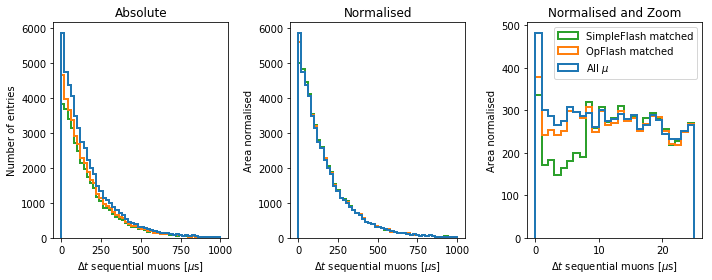

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

data = [time_dif_all,time_dif_op_matched, time_dif_simple_matched]
weight = [weights_all,weights_op_good, weights_simple_good]

ax[0].hist(data, histtype = 'step',lw=2, bins=50, range = (0,1000), label=[r'All $\mu$','OpFlash matched','SimpleFlash matched'])
ax[0].set_xlabel(r'$\Delta t$ sequential muons [$\mu$s]')
ax[0].set_ylabel(r'Number of entries')
ax[0].set_title(r'Absolute')

ax[1].hist(data, histtype = 'step',lw=2, bins=50, range = (0,1000), weights=weight)
ax[1].set_xlabel(r'$\Delta t$ sequential muons [$\mu$s]')
ax[1].set_ylabel(r'Area normalised')
ax[1].set_title(r'Normalised')

ax[2].hist(data, histtype = 'step',lw=2, bins=25, range = (0,25), weights=weight, label=[r'All $\mu$','OpFlash matched','SimpleFlash matched'])
ax[2].set_xlabel(r'$\Delta t$ sequential muons [$\mu$s]')
ax[2].set_ylabel(r'Area normalised')
ax[2].set_title(r'Normalised and Zoom')
ax[2].legend()

fig.tight_layout()
plt.savefig("./Output/CosmicFlash/muon_time_diff.pdf", bbox_inches="tight")

0.7423175315036478
31663


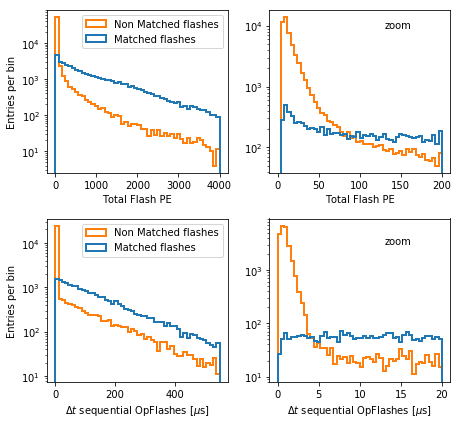

In [61]:
#Index(['dataset_prescale_factor', 'event', 'flash_abstime',
#       'flash_num_PMT10percent', 'flash_sy', 'flash_sz', 'flash_time',
#       'flash_totalPE', 'flash_width', 'flash_y', 'flash_z', 'num_flashes',
#       'run', 'subrun'],

fig, ax = plt.subplots(2, 2, figsize=(6.5, 6))

field = 'flash_totalPE'

data = [flash_dicts_mc[3].iloc[index_op_good][field], flash_dicts_mc[3].iloc[index_op_bad][field]]
labs = ['Matched flashes', 'Non Matched flashes']
ax[0][0].hist(data,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,4000))
ax[0][1].hist(data,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,200))
bins,_,_ = ax[1][0].hist([time_diff_op_matched,time_diff_op_bad],label=labs,histtype='step',lw=2,bins=50,density=0, range=(0,550))
ax[1][1].hist([time_diff_op_matched,time_diff_op_bad],label=labs,histtype='step',lw=2,bins=50,density=0, range=(0,20))

ax[0][0].set_xlabel('Total Flash PE')
ax[0][0].set_ylabel('Entries per bin')
ax[0][1].set_xlabel('Total Flash PE')
ax[1][0].set_ylabel('Entries per bin')
ax[1][0].set_xlabel(r'$\Delta t$ sequential OpFlashes [$\mu$s]')
ax[1][1].set_xlabel(r'$\Delta t$ sequential OpFlashes [$\mu$s]')

ax[0][0].legend(loc=0)
ax[1][0].legend(loc=0)
ax[0][1].text(130, 9000, 'zoom')
ax[1][1].text(13, 3000, 'zoom')

ax[1][1].set_yscale('log')
ax[1][0].set_yscale('log')
ax[0][1].set_yscale('log')
ax[0][0].set_yscale('log')

fig.tight_layout()
plt.savefig("./Output/CosmicFlash/flash_matched_PE.pdf", bbox_inches="tight")

print((bins[1][0]-bins[1][1])/len(time_diff_op_bad))
print(len(time_diff_op_bad))

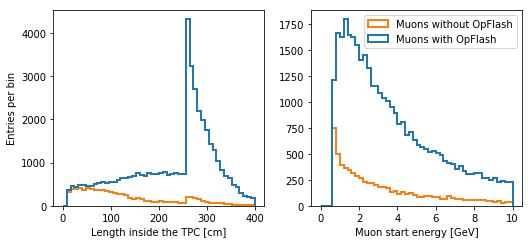

In [30]:
#(['event', 'fMc_part_inside', 'mc_end_inside', 'mc_endx', 'mc_endx_sce',
#       'mc_endx_tpc', 'mc_endy', 'mc_endy_sce', 'mc_endy_tpc', 'mc_endz',
#       'mc_endz_sce', 'mc_endz_tpc', 'mc_energy', 'mc_length', 'mc_length_tpc',
#       'mc_pdg_code', 'mc_process', 'mc_start_inside', 'mc_startmomentumx',
#       'mc_startmomentumy', 'mc_startmomentumz', 'mc_startx', 'mc_startx_sce',
#       'mc_startx_tpc', 'mc_starty', 'mc_starty_sce', 'mc_starty_tpc',
#       'mc_startz', 'mc_startz_sce', 'mc_startz_tpc', 'mc_status_code',
#       'mc_time', 'num_mcp', 'num_mcp_saved', 'run', 'subrun'],

fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))

field = 'mc_length_tpc'
data1 = [df_mcp_clean.iloc[index_mcp_good][field], df_mcp_clean.iloc[index_mcp_bad][field]]
field = 'mc_energy'
data2 = [df_mcp_clean.iloc[index_mcp_good][field], df_mcp_clean.iloc[index_mcp_bad][field]]


labs = ['Muons with OpFlash', 'Muons without OpFlash']
ax[0].hist(data1,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,400))
ax[1].hist(data2,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,10))

ax[0].set_xlabel('Length inside the TPC [cm]')
ax[1].set_xlabel('Muon start energy [GeV]')

ax[0].set_ylabel('Entries per bin')
ax[1].legend(loc='upper right')

fig.tight_layout()
plt.savefig("./Output/CosmicFlash/mc_muons1.pdf", bbox_inches="tight")

In [26]:
df_mcp_clean['mc_avgx_tpc'] = (df_mcp_clean['mc_startx_tpc']+df_mcp_clean['mc_endx_tpc'])/2
df_mcp_clean['mc_avgy_tpc'] = (df_mcp_clean['mc_starty_tpc']+df_mcp_clean['mc_endy_tpc'])/2
df_mcp_clean['mc_avgz_tpc'] = (df_mcp_clean['mc_startz_tpc']+df_mcp_clean['mc_endz_tpc'])/2

df_mcp_clean['mc_mom_x_yz'] = df_mcp_clean['mc_startmomentumx'] / (df_mcp_clean['mc_startmomentumy']**2+df_mcp_clean['mc_startmomentumz']**2)**0.5
df_mcp_clean['mc_mom_z_xy'] = df_mcp_clean['mc_startmomentumz'] / (df_mcp_clean['mc_startmomentumx']**2+df_mcp_clean['mc_startmomentumy']**2)**0.5
df_mcp_clean['mc_mom_y_zx'] = df_mcp_clean['mc_startmomentumy'] / (df_mcp_clean['mc_startmomentumz']**2+df_mcp_clean['mc_startmomentumx']**2)**0.5

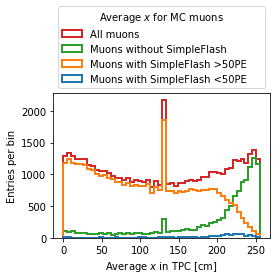

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

field = 'mc_avgx_tpc'

index_mcp_bad_simple = np.setdiff1d(index_mcp_all,index_mcp_good_simple)

mask_low_pe = np.array(index_mcp_good_simple)[np.array(flash_dicts_mc[2].iloc[index_simple_good]['flash_totalPE']<50)]
mask_high_pe = np.array(index_mcp_good_simple)[np.array(flash_dicts_mc[2].iloc[index_simple_good]['flash_totalPE']>50)]
data1 = [df_mcp_clean.iloc[mask_low_pe][field], df_mcp_clean.iloc[mask_high_pe][field], df_mcp_clean.iloc[index_mcp_bad_simple][field], df_mcp_clean.iloc[index_mcp_all][field]]

labs = ['Muons with SimpleFlash <50PE','Muons with SimpleFlash >50PE', 'Muons without SimpleFlash', 'All muons']
ax.hist(data1,label=labs,histtype='step',lw=2,bins=50,range=(0,256))
ax.set_xlabel(r'Average $x$ in TPC [cm]')
ax.set_ylabel('Entries per bin')
ax.legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=r'Average $x$ for MC muons', loc='lower center', mode='expand')
fig.tight_layout()
plt.savefig("./Output/CosmicFlash/mc_muons3.pdf", bbox_inches="tight")

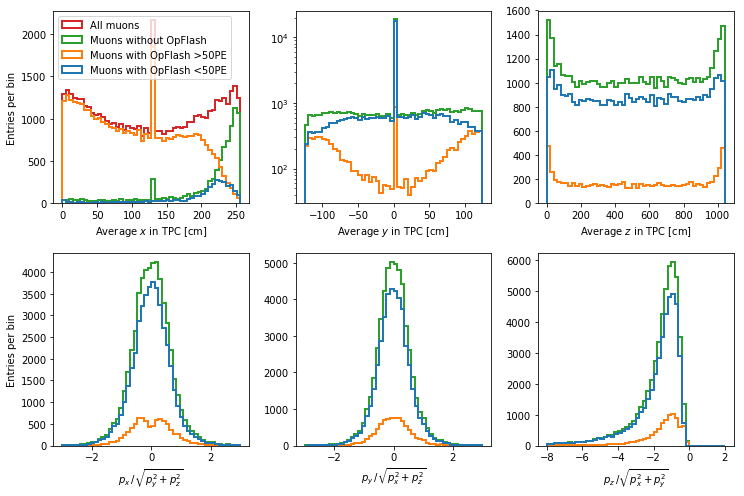

In [39]:
#(['event', 'fMc_part_inside', 'mc_end_inside', 'mc_endx', 'mc_endx_sce',
#       'mc_endx_tpc', 'mc_endy', 'mc_endy_sce', 'mc_endy_tpc', 'mc_endz',
#       'mc_endz_sce', 'mc_endz_tpc', 'mc_energy', 'mc_length', 'mc_length_tpc',
#       'mc_pdg_code', 'mc_process', 'mc_start_inside', 'mc_startmomentumx',
#       'mc_startmomentumy', 'mc_startmomentumz', 'mc_startx', 'mc_startx_sce',
#       'mc_startx_tpc', 'mc_starty', 'mc_starty_sce', 'mc_starty_tpc',
#       'mc_startz', 'mc_startz_sce', 'mc_startz_tpc', 'mc_status_code',
#       'mc_time', 'num_mcp', 'num_mcp_saved', 'run', 'subrun'],

 
fig, ax = plt.subplots(2, 3, figsize=(10.5, 7))

field = 'mc_avgx_tpc'
mask_low_pe = np.array(index_mcp_good)[np.array(flash_dicts_mc[3].iloc[index_op_good]['flash_totalPE']<50)]
mask_high_pe = np.array(index_mcp_good)[np.array(flash_dicts_mc[3].iloc[index_op_good]['flash_totalPE']>50)]

data1 = [df_mcp_clean.iloc[mask_low_pe][field], df_mcp_clean.iloc[mask_high_pe][field], df_mcp_clean.iloc[index_mcp_bad][field], df_mcp_clean.iloc[index_mcp_all][field]]

field = 'mc_avgy_tpc'
data2 = [df_mcp_clean.iloc[index_mcp_good][field], df_mcp_clean.iloc[index_mcp_bad][field], df_mcp_clean.iloc[index_mcp_all][field]]
field = 'mc_avgz_tpc'
data3 = [df_mcp_clean.iloc[index_mcp_good][field], df_mcp_clean.iloc[index_mcp_bad][field], df_mcp_clean.iloc[index_mcp_all][field]]

field = 'mc_mom_x_yz'
data4 = [df_mcp_clean.iloc[index_mcp_good][field], df_mcp_clean.iloc[index_mcp_bad][field], df_mcp_clean.iloc[index_mcp_all][field]]
field = 'mc_mom_z_xy'
data5 = [df_mcp_clean.iloc[index_mcp_good][field], df_mcp_clean.iloc[index_mcp_bad][field], df_mcp_clean.iloc[index_mcp_all][field]]
field = 'mc_mom_y_zx'
data6 = [df_mcp_clean.iloc[index_mcp_good][field], df_mcp_clean.iloc[index_mcp_bad][field], df_mcp_clean.iloc[index_mcp_all][field]]

labs = ['Muons with OpFlash <50PE','Muons with OpFlash >50PE', 'Muons without OpFlash', 'All muons']
#ax[1][0].hist(data1,label=labs,histtype='step',lw=2,bins=50,density=1,range=(0,256))
#ax[1][1].hist(data2,label=labs,histtype='step',lw=2,bins=50,density=1,range=(-125,125))
#ax[1][2].hist(data3,label=labs,histtype='step',lw=2,bins=50,density=1,range=(0,1040))

ax[0][0].hist(data1,label=labs,histtype='step',lw=2,bins=50,range=(0,256))
ax[0][1].hist(data2,label=labs,histtype='step',lw=2,bins=50,range=(-125,125))
ax[0][2].hist(data3,label=labs,histtype='step',lw=2,bins=50,range=(0,1040))

ax[1][0].hist(data4,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-3,3))
ax[1][1].hist(data5,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-3,3))
ax[1][2].hist(data6,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-8,2))

ax[0][0].set_xlabel(r'Average $x$ in TPC [cm]')
ax[0][1].set_xlabel(r'Average $y$ in TPC [cm]')
ax[0][2].set_xlabel(r'Average $z$ in TPC [cm]')
ax[0][1].set_yscale('log')

ax[1][0].set_xlabel(r'$p_x \:/ \sqrt{p_y^2+p_z^2}$')
ax[1][1].set_xlabel(r'$p_y \:/ \sqrt{p_x^2+p_z^2}$')
ax[1][2].set_xlabel(r'$p_z \:/ \sqrt{p_x^2+p_y^2}$')

ax[0][0].set_ylabel('Entries per bin')
ax[1][0].set_ylabel('Entries per bin')
ax[0][0].legend(loc='upper left')

fig.tight_layout()
plt.savefig("./Output/CosmicFlash/mc_muons2.pdf", bbox_inches="tight")

Number of muon we tried to match: 199323
Number of op-matched muons: 154974 ( 198040  opflashes)
Number of simple-matched muons: 149890 ( 185837  simpleflashes)


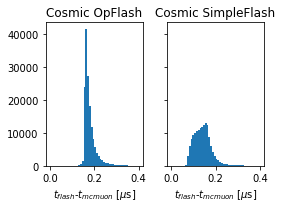

In [90]:
op_diff_times = np.array(op_diff_times)
simple_diff_times = np.array(simple_diff_times)
fig, ax = plt.subplots(1, 2, figsize=(4, 3),sharey=True,sharex=True)
ax[0].hist(op_diff_times, range=(0,0.4),bins=50)
ax[0].set_title('Cosmic OpFlash')
ax[0].set_xlabel(r'$t_{flash}$-$t_{mcmuon}$ [$\mu$s]')
ax[1].hist(simple_diff_times, range=(0,0.4),bins=50)
ax[1].set_title('Cosmic SimpleFlash')
ax[1].set_xlabel(r'$t_{flash}$-$t_{mcmuon}$ [$\mu$s]')

fig.tight_layout()
plt.savefig("./Output/CosmicFlash/flash_time_match.pdf", bbox_inches="tight")

print('Number of muon we tried to match:',n_muons)
print('Number of op-matched muons:',len(op_diff_times[(op_diff_times>fl_diff_start) & (op_diff_times<fl_diff_end)]),'(',n_op,' opflashes)')
print('Number of simple-matched muons:',len(simple_diff_times[(simple_diff_times>fl_diff_start) & (simple_diff_times<fl_diff_end)]),'(',n_simple,' simpleflashes)')

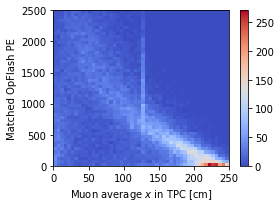

In [59]:
#print(index_simple_good)
data_fl = flash_dicts_mc[3].iloc[index_op_good]['flash_totalPE']
#data_fl = flash_dicts_mc[2].iloc[index_simple_good]['flash_totalPE']
data_mc_avgx = df_mcp_clean.iloc[index_mcp_good]['mc_avgx_tpc']

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

c = ax.hist2d(data_mc_avgx, data_fl, range=((0,250),(0,2500)), cmap='coolwarm', bins=(50,50))
plt.colorbar(c[3], ax=ax)
ax.set_xlabel('Muon average $x$ in TPC [cm]')
ax.set_ylabel('Matched OpFlash PE')
fig.tight_layout()
plt.savefig("./Output/CosmicFlash/mux_flashPE.pdf", bbox_inches="tight")

In [24]:
# these are a try-out to make plot functions, specifically for the flash data/MC

def plot_data_mc_ratio(df_mc, df_data, param_dict):
    fig, ax = plt.subplots(2, 1, figsize=(3.5, 4.2), sharex = 'col', gridspec_kw = {'height_ratios':[3, 1]})
    ax[0].set_title(param_dict['title'])
    lab = 'Corsika open ({0:.1f} kHz)'.format(event_dict_mc[param_dict['name']].mean()*param_dict['extra']/1000)
    edges=np.linspace(param_dict['x_min'],param_dict['x_max'], param_dict['bins']+1)
    weights=event_dict_mc['dataset_prescale_factor']
    bins_mc, _, _ = ax[0].hist(event_dict_mc[param_dict['name']], bins=edges, histtype='step', lw=2, label=lab, weights=weights)
    lab = 'Data unbiased ({0:.1f} kHz)'.format(event_dict_data[param_dict['name']].mean()*param_dict['extra']/1000)
    bins_data, _, _ = ax[0].hist(event_dict_data[param_dict['name']], bins=edges, histtype='step', lw=2, label=lab)
    
    ax[0].legend()
    if 'x_ticks' in param_dict:
        ax[1].set_xticks(param_dict['x_ticks'])
    ax[1].set_xlabel(param_dict['x_label'])
    
    fig.tight_layout()

# Plot grid where every part of grid is in same df
def plot_data_mc_22(df_mc, df_data, param_dict_list, title):
    fig, ax = plt.subplots(2, 2, figsize=(8, 7))
    ax = np.hstack(ax)
    for i,param_dict in enumerate(param_dict_list):
        lab = 'Corsika open ({0:.1f} kHz)'.format(event_dict_mc[param_dict['name']].mean()*param_dict['extra']/1000)
        weights=event_dict_mc['dataset_prescale_factor']
        edges=np.linspace(param_dict['x_min'],param_dict['x_max'], param_dict['bins']+1)
        bins_mc, edges, _ = ax[i].hist(df_mc[param_dict['name']], bins=edges, histtype='step', lw=2, label=lab, color='C0', weights=weights)
        temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
        temp_err = np.sqrt(temp*mc_weight)
        ax[i].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
        
        lab = 'Data unbiased ({0:.1f} kHz)'.format(event_dict_data[param_dict['name']].mean()*param_dict['extra']/1000)
        bins_data, _, _ = ax[i].hist(df_data[param_dict['name']], bins=edges, histtype='step', lw=2, label=lab, color='C1')
        temp = np.append(bins_data, bins_data[-1])
        ax[i].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
        ax[i].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=param_dict['title'], loc='lower center', mode='expand')
        if 'x_ticks' in param_dict:
            ax[i].set_xticks(param_dict['x_ticks'])
        ax[i].set_xlabel(param_dict['x_label'])
    fig.tight_layout()
    plt.savefig("./Output/CosmicFlash/"+title+".pdf", bbox_inches="tight")
    
#plot grid where every part is in differend df
def plot_data_mc_dict(df_mc_list, df_data_list, legend_title_list,param_dict, title):
    fig, ax = plt.subplots(2, 2, figsize=(8, 7))
    ax = np.hstack(ax)
    for i,(df_mc, df_data,legend_title) in enumerate(zip(df_mc_list,df_data_list,legend_title_list)):
        if 'logx' in param_dict:
            ax[i].set_xscale("log", nonposx='clip')
            edges=np.logspace(np.log10(param_dict['x_min']),np.log10(param_dict['x_max']), param_dict['bins']+1)
        else:
            edges=np.linspace(param_dict['x_min'],param_dict['x_max'], param_dict['bins']+1)
        weights=df_mc['dataset_prescale_factor']
        lab = 'Corsika open ({0:.0f} entries)'.format(df_mc[param_dict['name']].count()*df_mc['dataset_prescale_factor'][0])
        bins_mc, _, _ = ax[i].hist(df_mc[param_dict['name']], weights=weights,
                                       bins=edges, histtype='step', lw=2, label=lab, color='C0')
        temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
        temp_err = np.sqrt(temp*mc_weight)
        ax[i].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
        lab = 'Data unbiased ({0:.0f} entries)'.format(df_data[param_dict['name']].count())
        bins_data, _, _ = ax[i].hist(df_data[param_dict['name']],
                                     bins=edges, histtype='step', lw=2, label=lab, color='C1')
        temp = np.append(bins_data, bins_data[-1])
        ax[i].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
        
        ax[i].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=legend_title, loc='lower center', mode='expand')
        ax[i].set_xlabel(param_dict['x_label'])
        old_y_lim = ax[i].get_ylim()[1]
        ax[i].fill_between([param_dict['x_min'],50], [0,0], [old_y_lim,old_y_lim], alpha=0.1, color='k')
        ax[i].set_ylim(0,old_y_lim)
    fig.tight_layout()
    plt.savefig("./Output/CosmicFlash/"+title+".pdf", bbox_inches="tight")

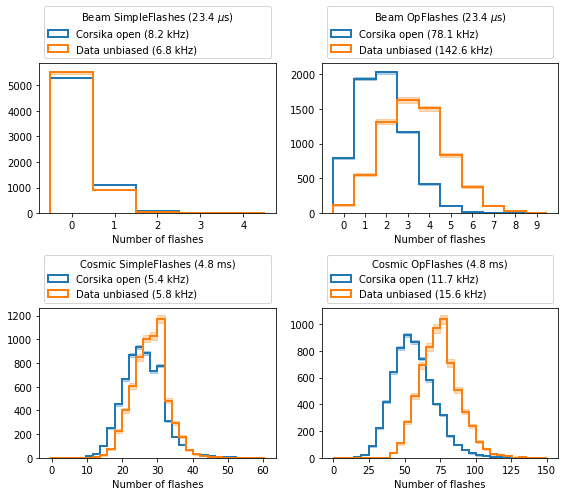

In [25]:
# Plot the number of flashes

num_simplebeamflashes = {
    "name": 'num_simplebeamflashes',
    "title": r'Beam SimpleFlashes (23.4 $\mu$s)',
    "bins": 5,
    "x_min": -.5,
    "x_max": 4.5,
    "x_label": r'Number of flashes',
    "x_ticks": range(5),
    "extra": 1/23.4e-6
}

num_opbeamflashes = {
    "name": 'num_opbeamflashes',
    "title": r'Beam OpFlashes (23.4 $\mu$s)',
    "bins": 10,
    "x_min": -.5,
    "x_max": 9.5,
    "x_label": r'Number of flashes',
    "x_ticks": range(10),
    "extra": 1/23.4e-6
}

num_simplecosmicflashes = {
    "name": 'num_simplecosmicflashes',
    "title": r'Cosmic SimpleFlashes (4.8 ms)',
    "bins": 30,
    "x_min": -.5,
    "x_max": 60.5,
    "x_label": r'Number of flashes',
    "extra": 1/4.8e-3
}

num_opcosmicflashes = {
    "name": 'num_opcosmicflashes',
    "title": r'Cosmic OpFlashes (4.8 ms)',
    "bins": 30,
    "x_min": -.5,
    "x_max": 150.5,
    "x_label": r'Number of flashes',
    "extra": 1/4.8e-3
}

plotlist = [num_simplebeamflashes, num_opbeamflashes, num_simplecosmicflashes, num_opcosmicflashes]
plot_data_mc_22(event_dict_mc, event_dict_data, plotlist,'number_flashes')

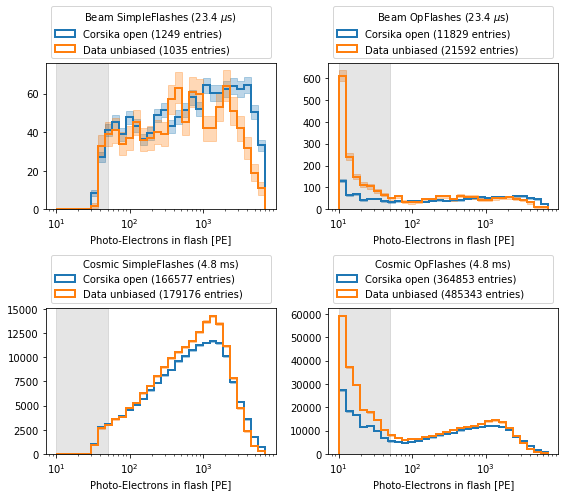

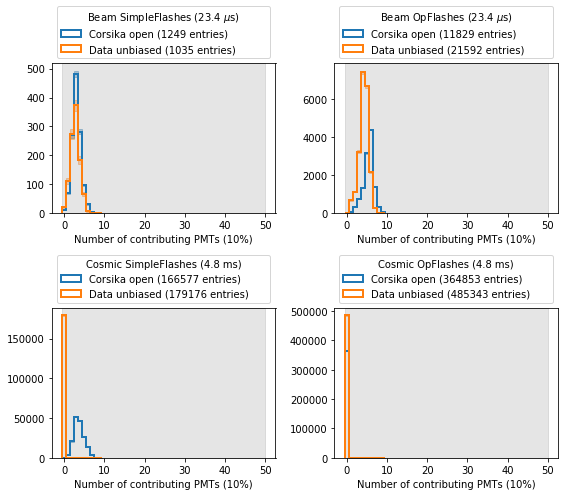

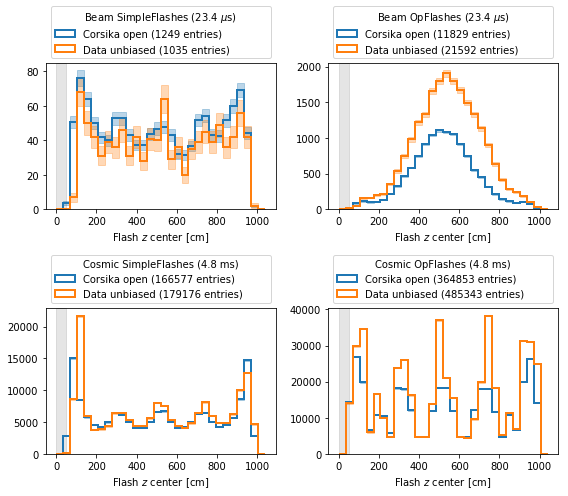

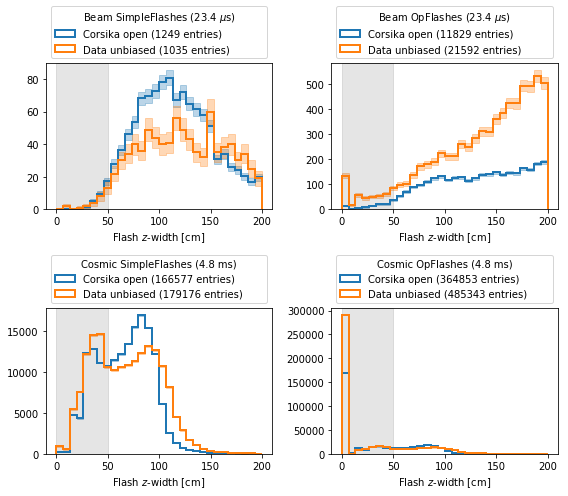

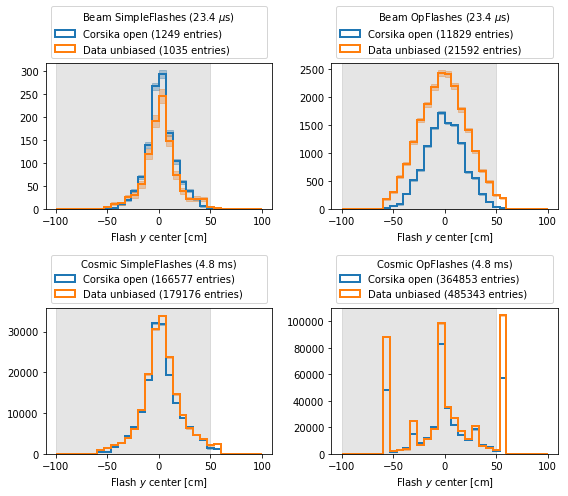

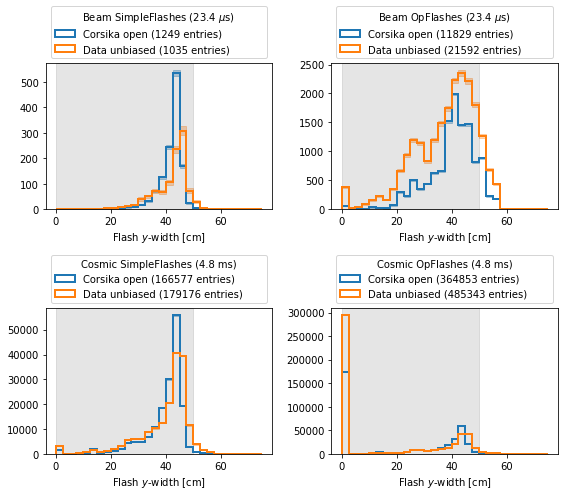

In [23]:
# Make plots for y,z,sy,sz,PE and PMT fraction
legend_title_list = [r'Beam SimpleFlashes (23.4 $\mu$s)', r'Beam OpFlashes (23.4 $\mu$s)', r'Cosmic SimpleFlashes (4.8 ms)', r'Cosmic OpFlashes (4.8 ms)']

PE = {
    "name": 'flash_totalPE',
    "bins": 30,
    "x_min": 10,
    "x_max": 7000,
    "x_label": r'Photo-Electrons in flash [PE]',
    "logx": 'logx'
}

z = {
    "name": 'flash_z',
    "bins": 30,
    "x_min": 0,
    "x_max": 1040,
    "x_label": r'Flash $z$ center [cm]',
}

sz = {
    "name": 'flash_sz',
    "bins": 30,
    "x_min": 0,
    "x_max": 200,
    "x_label": r'Flash $z$-width [cm]'
}

y = {
    "name": 'flash_y',
    "bins": 30,
    "x_min": -100,
    "x_max": 100,
    "x_label": r'Flash $y$ center [cm]',
}

sy = {
    "name": 'flash_sy',
    "bins": 30,
    "x_min": 0,
    "x_max": 75,
    "x_label": r'Flash $y$-width [cm]'
}

fracPMT = {
    "name": 'flash_num_PMT10percent',
    "bins": 10,
    "x_min": -0.5,
    "x_max": 9.5,
    "x_label": r'Number of contributing PMTs (10%)'
}


plot_data_mc_dict(flash_dicts_mc, flash_dicts_data, legend_title_list,PE, 'total_PE')
plot_data_mc_dict(flash_dicts_mc, flash_dicts_data, legend_title_list,fracPMT, 'fracPMT')
plot_data_mc_dict(flash_dicts_mc, flash_dicts_data, legend_title_list,z, 'flash_z')
plot_data_mc_dict(flash_dicts_mc, flash_dicts_data, legend_title_list,sz, 'flash_sz')
plot_data_mc_dict(flash_dicts_mc, flash_dicts_data, legend_title_list,y, 'flash_y')
plot_data_mc_dict(flash_dicts_mc, flash_dicts_data, legend_title_list,sy, 'flash_sy')

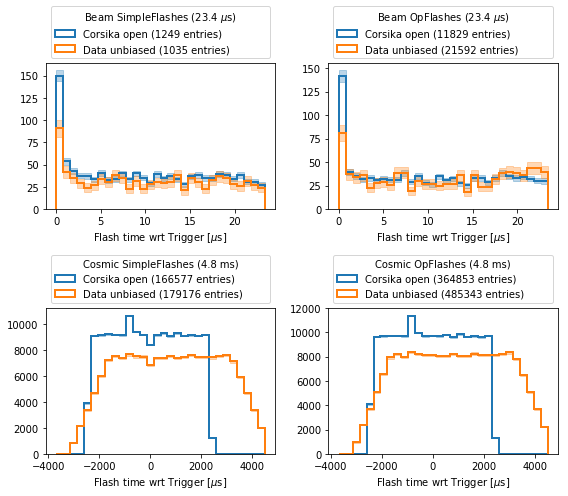

In [23]:
str_query='flash_totalPE>50'
# Plot for the flash timings, this we will do custom!
legend_title_list = [r'Beam SimpleFlashes (23.4 $\mu$s)', r'Beam OpFlashes (23.4 $\mu$s)', r'Cosmic SimpleFlashes (4.8 ms)', r'Cosmic OpFlashes (4.8 ms)']
fig, ax = plt.subplots(2, 2, figsize=(8, 7))
ax = np.hstack(ax)
for i,(df_mc, df_data,legend_title) in enumerate(zip(flash_dicts_mc,flash_dicts_data,legend_title_list)):
    if 'eam' in legend_title:
        edges=np.linspace(-0,23.4, 31)
    else:
        edges=np.linspace(-3700,4500, 31)
    weights=df_mc.query(str_query)['dataset_prescale_factor']
    lab = 'Corsika open ({0:.0f} entries)'.format(df_mc['flash_time'].count()*df_mc['dataset_prescale_factor'][0])
    bins_mc, edges, _ = ax[i].hist(df_mc.query(str_query)['flash_time'], bins=edges, histtype='step', lw=2, label=lab, color='C0', weights=weights)
    temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
    temp_err = np.sqrt(temp*mc_weight)
    ax[i].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')


    lab = 'Data unbiased ({0:.0f} entries)'.format(df_data['flash_time'].count())
    bins_data, _, _ = ax[i].hist(df_data.query(str_query)['flash_time'], bins=edges, histtype='step', lw=2, label=lab, color='C1')
    temp = np.append(bins_data, bins_data[-1]) # padding with the same value in the end
    ax[i].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')

    ax[i].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=legend_title, loc='lower center', mode='expand')
    ax[i].set_xlabel(r'Flash time wrt Trigger [$\mu$s]')
fig.tight_layout()
plt.savefig("./Output/CosmicFlash/flash_time.pdf", bbox_inches="tight")